# Spectral density as a function of $U_{IB}$ #

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import h5py
import numpy as np
import class_utils as class_utils
from class_grid import Grid
from class_params import Params
from class_groundstate import groundstate
from class_excitations import excitations
from class_vertices import vertices
from class_perturbation import perturbative
from class_self_energy import Self_Energy
from class_io import IO
from class_plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


### For different $U_{IB}$ values

In [4]:
config_path = "config.yml" 

dJU = 0.2 # which hopping value are we fixing to
muU = np.sqrt(2) - 1 # which chemical potential we are fixing to

output_dir = class_utils.create_output_dir()
config = class_utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]
cutoff = config["physics"]["cutoff"]
N = config["physics"]["N"]
M = Lx * Ly

grid = Grid(Lx, Ly)

num_en = 100 # 100
num_UIB = 100 # 100
en_vector = np.linspace(-1,1,num_en)
UIBs = np.linspace(-1, 1, num_UIB)

In [5]:
omega0s = np.zeros(len(UIBs))
omega1s = np.zeros(len(UIBs))
omega2s = np.zeros(len(UIBs))

SE = np.zeros((7, len(en_vector)), dtype=np.complex128)  #7 rows for each contribution, num_en columns ##V: why 7?


#V:  Add poles to this plot!!!
T11 = np.zeros((len(UIBs), len(en_vector)), dtype=np.complex128)
T12 = np.zeros((len(UIBs), len(en_vector)), dtype=np.complex128)
T21 = np.zeros((len(UIBs), len(en_vector)), dtype=np.complex128)
T22 = np.zeros((len(UIBs), len(en_vector)), dtype=np.complex128)
T22_F = np.zeros((len(UIBs), len(en_vector)), dtype=np.complex128)
SE_SI = np.zeros((len(UIBs), len(en_vector)), dtype=np.complex128)

for count, UIB in enumerate(UIBs):
    params = Params(N, dJU, muU, UIB, cutoff)
    print(count,UIB)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    psi0 = gs.psi0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    Pert_Energy = pert.perturbative_energy(n0)
    omega0s[count] = Pert_Energy[0]
    omega1s[count] = Pert_Energy[1]
    omega2s[count] = Pert_Energy[2]

    for epol_ind in range(len(en_vector)):
        Epol = en_vector[epol_ind]
        self_energy = Self_Energy(Epol, grid, params, verts, omegaklambda)
        #output = self_energy.calculate_self_energy()
        output = self_energy.calculate_self_energy_perturbative() # perturbative result
        SE[:, epol_ind] = output
    #The zeroth element is the full self energy minus w, used for finding the zero crossings.
    T11[count, :] = SE[1, :]
    T12[count, :] = SE[2, :]
    T21[count, :] = SE[3, :]
    T22[count, :] = SE[4, :]
    T22_F[count, :] = SE[5, :]
    SE_SI[count, :] = SE[6, :]

0 -1.0
1 -0.9797979797979798
2 -0.9595959595959596
3 -0.9393939393939394
4 -0.9191919191919192
5 -0.898989898989899
6 -0.8787878787878788
7 -0.8585858585858586
8 -0.8383838383838383
9 -0.8181818181818181
10 -0.797979797979798
11 -0.7777777777777778
12 -0.7575757575757576
13 -0.7373737373737373
14 -0.7171717171717171
15 -0.696969696969697
16 -0.6767676767676767
17 -0.6565656565656566
18 -0.6363636363636364
19 -0.6161616161616161
20 -0.5959595959595959
21 -0.5757575757575757
22 -0.5555555555555556
23 -0.5353535353535352
24 -0.5151515151515151
25 -0.4949494949494949
26 -0.4747474747474747
27 -0.4545454545454545
28 -0.43434343434343425
29 -0.41414141414141414
30 -0.3939393939393939
31 -0.3737373737373737
32 -0.3535353535353535
33 -0.33333333333333326
34 -0.31313131313131304
35 -0.2929292929292928
36 -0.2727272727272727
37 -0.2525252525252525
38 -0.23232323232323226
39 -0.21212121212121204
40 -0.19191919191919182
41 -0.1717171717171716
42 -0.1515151515151515
43 -0.13131313131313127
44 -0.11

In [6]:
# construct the spectral function and T-matrices 
SpectralFuncs = np.zeros((len(UIBs), len(en_vector)))
TFuncs = np.zeros((len(UIBs), len(en_vector)),dtype=np.complex128)
#UIB_map = UIBs * np.ones_like(SpectralFuncs)
dOmega = en_vector[1] - en_vector[0]
eta = 0.01

#
for count in range(0, len(UIBs)):
    SpectralFuncs[count, :] = dOmega * (-2) * np.imag(1./(en_vector - SE_SI[count] + 1j * eta))
    TFuncs[count, :] = (T11[count] + T12[count] + T21[count] + T21[count] + T22[count]) + T22_F[count]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


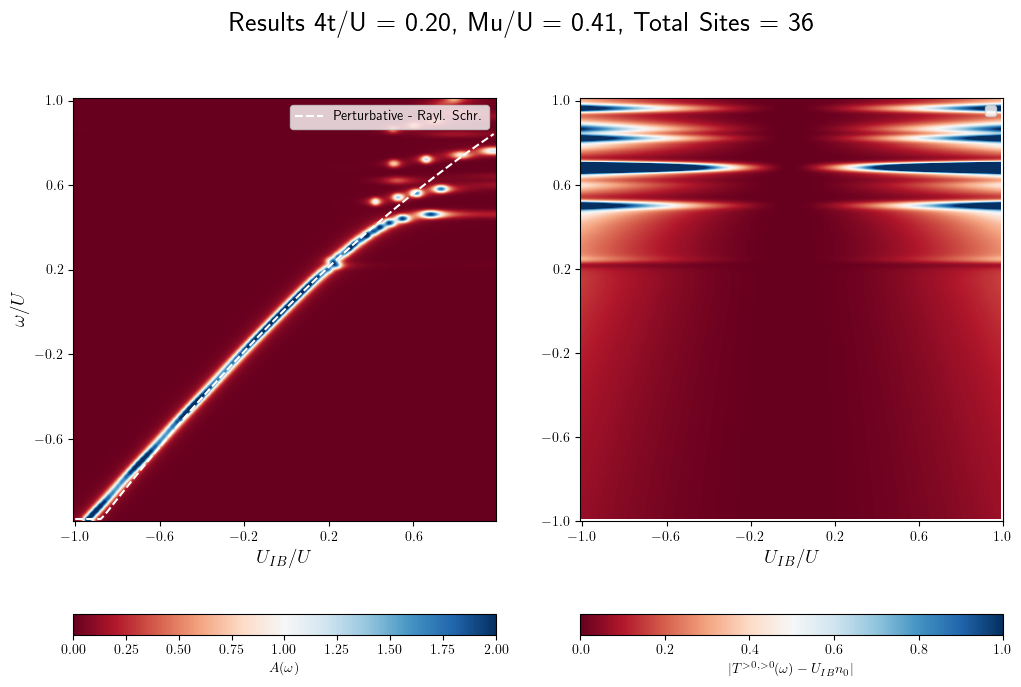

In [11]:
plt.rcParams['text.usetex'] = True

threshold = 0.00

filtered_SpectralFuncs = np.where(abs(SpectralFuncs) > threshold, SpectralFuncs, 0)  ##### CHECK IF THIS STILL MAKES SENSE!!!


# Rotate the image by -90 degrees
SpectralFuncs_rot = np.rot90(filtered_SpectralFuncs, 1)
TFuncs_rot = np.rot90(TFuncs, 1)


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,8))

# Create the plot
# Set the aspect ratio to the ratio of the number of x points to the number of y points
aspect_ratio = 1
im1 = ax1.imshow(SpectralFuncs_rot, interpolation = 'bicubic', cmap='RdBu', aspect = aspect_ratio)
im2 = ax2.imshow(np.abs(TFuncs_rot - n0*UIBs), interpolation = 'bicubic',cmap='RdBu', aspect = aspect_ratio)


# Select a subset of dJUs and en_vector for the ticks
num_xticks = 6
num_yticks = 6

xticks = np.linspace(0, SpectralFuncs_rot.shape[1], num_xticks, endpoint=True, dtype=int)
yticks = np.linspace(0, SpectralFuncs_rot.shape[0], num_yticks, endpoint=True, dtype=int)

xticklabels = np.round(np.linspace(min(UIBs), max(UIBs), num_xticks), 2)
yticklabels = np.round(np.linspace(max(en_vector), min(en_vector), num_yticks), 2)

# Format the labels in LaTeX
xticklabels = [r'$\mathrm{{{}}}$'.format(label) for label in xticklabels]
yticklabels = [r'$\mathrm{{{}}}$'.format(label) for label in yticklabels]

ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax1.set_xticklabels(xticklabels)
ax1.set_yticklabels(yticklabels)
ax2.set_xticklabels(xticklabels)
ax2.set_yticklabels(yticklabels)
ax1.set_xlabel(r'$U_{IB}/U$', fontsize=14)
ax2.set_xlabel(r'$U_{IB}/U$', fontsize=14)
ax1.set_ylabel(r'$\omega/U$', fontsize=14)

cb1 = plt.colorbar(im1,orientation="horizontal", label = "$A(\omega)$")
cb2 = plt.colorbar(im2,orientation="horizontal", label = "$|T^{>0,>0}(\omega) - U_{IB}n_0|$")
im1.set_clim(0, 2)
im2.set_clim(0, 1)

# # Create an axes divider and add the colorbar to it
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)
# Create a secondary y-axis

X, Y = np.meshgrid(UIBs, omega0s + omega1s + omega2s)
# ax2 = ax.twinx()
# Transform the y-coordinates of the plot to match the image coordinates
plot_x = np.interp(UIBs, (UIBs.min(), UIBs.max()), (0, SpectralFuncs_rot.shape[1]-1))
plot_y = SpectralFuncs_rot.shape[0] - 1 - np.interp(omega0s + omega1s + omega2s, (en_vector.min(), en_vector.max()), (0, SpectralFuncs_rot.shape[0]-1))

# Overlay the plot on top of the imshow figure
fig.suptitle(f"Results 4t/U = {dJU:0.2f}, Mu/U = {muU:0.2f}, Total Sites = {M}", fontsize = 20)
ax1.plot(plot_x, plot_y, linestyle = '--', label='Perturbative - Rayl. Schr.', color='white', linewidth=1.5)

ax1.legend()
ax2.legend()

plt.show()

In [8]:
## Save the figure 
filename = f'../figs/Spectral_Line_UIB_Scan/dJU_{dJU}_Mu_{muU:.2f}_M_{grid.M}_N_{N}_num_en_{num_en}_num_UIB_{num_UIB}.pdf'
fig.savefig(filename, dpi=300, bbox_inches='tight')



In [9]:
# Save the data

# Code to save results for different UIBs
filename = f'./data/Spectral_Line_UIB_Scan/dJU_{dJU}_Mu_{muU:.2f}_M_{grid.M}_N_{N}_num_en_{num_en}_num_UIB_{num_UIB}.hdf5'

with h5py.File(filename, 'w') as f:
    f.create_dataset('UIBs', data=UIBs)
    f.create_dataset('en_vector', data=en_vector)
    f.create_dataset('omega0s', data=omega0s)
    f.create_dataset('omega1s', data=omega1s)
    f.create_dataset('omega2s', data=omega2s)
    for i, UIB in enumerate(UIBs):
    # Create a group for this dJU value
        group = f.create_group(f'UIB_{UIB}')

        # Store the arrays in this group
        group.create_dataset('T11', data=T11[i, :])
        group.create_dataset('T12', data=T12[i, :])
        group.create_dataset('T21', data=T21[i, :])
        group.create_dataset('T22', data=T22[i, :])
        group.create_dataset('T22_SE', data=T22_F[i, :])
        group.create_dataset('SE_SI', data=SE_SI[i, :])
    

    # Create attributes for your parameters
    f.attrs['dJU'] = dJU
    f.attrs['muU'] = muU
    f.attrs['Lx'] = grid.Lx
    f.attrs['Ly'] = grid.Ly
    f.attrs['N'] = N


    UIBs = f['UIBs'][:]
    en_vector = f['en_vector'][:]
    omega0s = f['omega0s'][:]
    omega1s = f['omega1s'][:]
    omega2s = f['omega2s'][:]

    T11 = []
    T12 = []
    T21 = []
    T22 = []
    T22_SE = []
    SE_SI = []

    for count, UIB in enumerate(UIBs):
        group = f[f'UIB_{UIB}']
        T11.append(group['T11'][:])
        T12.append(group['T12'][:])
        T21.append(group['T21'][:])
        T22.append(group['T22'][:])
        T22_SE.append(group['T22_SE'][:])
        SE_SI.append(group['SE_SI'][:])